# Trapalho Prático 2: Realidade Aumentada
**aluno:** Marcos Vinicius Moreira Santos

**matrícula:** 2018054982

*O video foi gravado em 1080p max infelizmente a compressão do youtube 
deixou o video em baixa resolução*

**Youtube Video**: https://youtu.be/KFhsjit19Bs

In [3]:
import cv2
import numpy as np

import math

from matplotlib import pyplot as plt
from OpenGL.GL import *
from OpenGL.GLU import *

import pygame as pg

from pygame.locals import *
from PIL import Image
from objloader import *

pygame 2.1.2 (SDL 2.0.18, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Calibração da Camera

A camera foi calibrada utilizando o toolbox para octave: **github.com/nghiaho12/camera_calibration_toolbox_octave**

In [4]:
CAMERA = np.array([[407.49019,   0., 311.90163],
                   [  0., 405.70205, 228.63810],
                   [  0.,        0.,        1.]])

DISTCOEFS = np.array([ 0.08273,   -0.26859,   -0.00485,   -0.00406,  0.00000 ])

## Leitura do template e do video de entrada

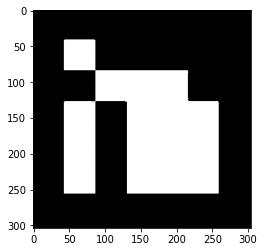

In [5]:
template = cv2.imread('alvo.jpeg')

template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

_, template = cv2.threshold(template, 127, 255, cv2.THRESH_BINARY)

plt.imshow(template, cmap='gray')

cap = cv2.VideoCapture('entrada.mp4')

ret, frame = cap.read()

## Pipeline pra detectar templates:

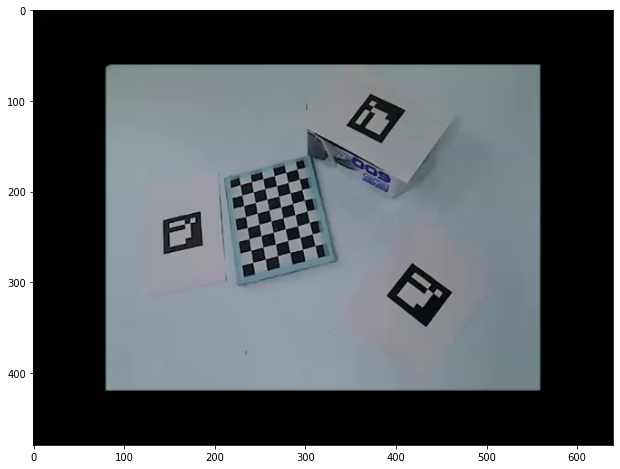

In [6]:
# se essa variavel for True o
# a orientação de cada template 
# será mostrada no video final
draw_axis = False

plt.subplots(figsize=(15, 8))
plt.imshow(frame, cmap='gray')

### 1. Detectar candidatos a template

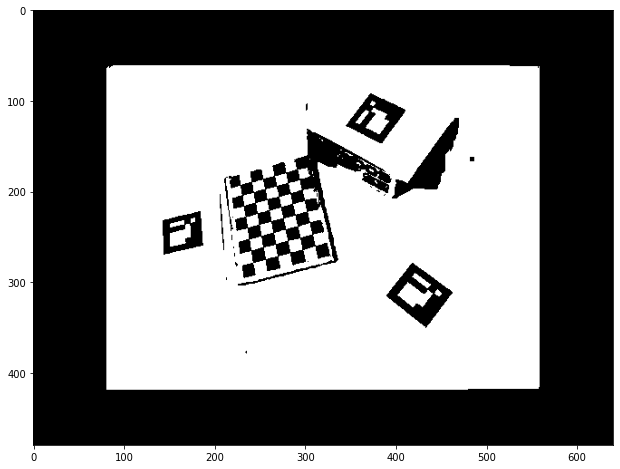

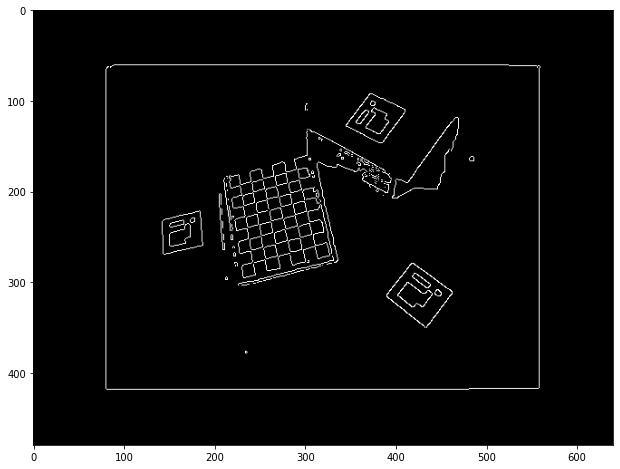

In [7]:
# Função que retorna as arestas de uma imagem
def frame_edges(frame):
    return cv2.Canny(frame, 10, 300)

# Função que retorna a imagem binaria do frame de entrada
def frame_binary(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    
    ret, frame = cv2.threshold(frame, 127, 255, cv2.THRESH_BINARY) 
    return frame

plt.subplots(figsize=(15, 8))
plt.imshow(frame_binary(frame), cmap='gray')

plt.subplots(figsize=(15, 8))
plt.imshow(frame_edges(frame_binary(frame)), cmap='gray')

Dado que o template tem um formato quadrado e tem área sempre maior que os quadrados do tabuleiro e sempre menor que o tabuleiro em si, a primeira etapa do processo é extrair todos os contornos quadrados que tem área dentro de um determinado intervalo.

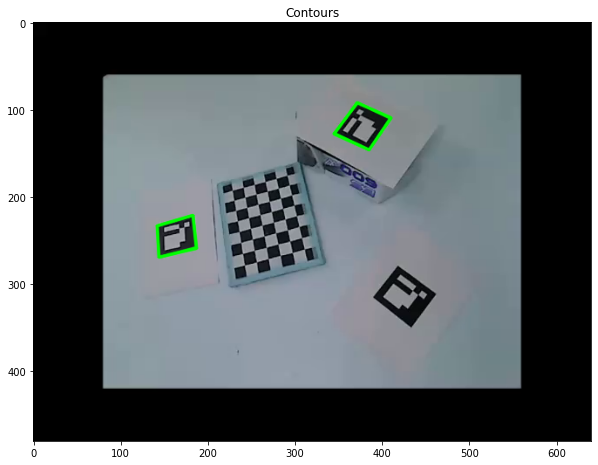

In [8]:
# Função que retorna os contornos de um frame
def frame_contours(frame):
    frame = frame_binary(frame)
    frame = frame_edges(frame);

    contours, hierarchy = cv2.findContours(image=frame, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    
    return contours

# Função que recebe os contornos de um frame e retorna somente os contornos quadrados
# com área dentro de um determinado intervalo
def square_contours(contours, intev_min=1000, interv_max=100000):
    squares = []

    for countour in contours:
        
        length = cv2.arcLength(countour, True)
        countour = cv2.approxPolyDP(countour, length*0.015, True)
        
        is_square = len(countour) == 4
        is_convex = cv2.isContourConvex(countour)
        is_medium = cv2.contourArea(countour) > intev_min and cv2.contourArea(countour) < interv_max
        
        # verificar as condições do contorno ser convexo e ter área 
        # dentro de um determinado interval salva performance
        if is_square and is_convex and is_medium:
            squares.append(countour)

    return squares


# Função auxiliar para printar os contornos na tela
def display_contours(frame, contours, fig_size=(10, 8), title="Contours"): 
    image = frame.copy()

    image = cv2.drawContours(image=image, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    
    plt.subplots(figsize=fig_size)

    plt.imshow(image, cmap='gray'), plt.title(title)

    plt.show()


contours = square_contours(frame_contours(frame))

display_contours(frame, contours)

### 2. Casamento dos candidatos com o template em diferentes ângulos

Para testar os candidatos é calculado uma homografia do candidato para o template, o candidato é rotacionado por um ângulo multiplo de 90, e então a média da soma dos erros absolutos de cada pixel é computada como erro. O candidato com menor valor de erro, e com valor absoluto menor que 20.6 é casado com o template.

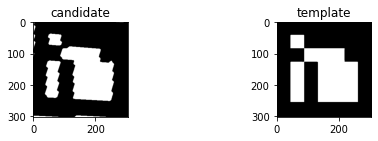

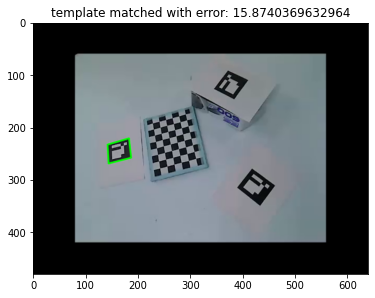

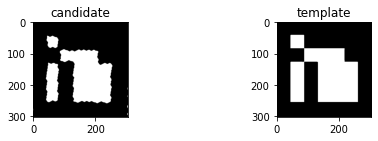

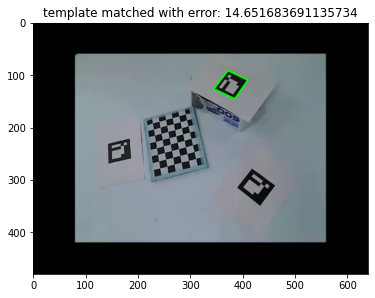

In [9]:
# Valores usados para computar a posição do template no mundo


# DX e DY são a variação na posição x e y respectivamente do centro do
# template no mundo, logo o template tem 2*DX de largura e 2*DY de altura
DX = 0.5
DY = 0.5

# CENTER_X, CENTER_Y e CENTER_Z são as coordenadas do centro do template no 
# mundo em x, y e z respectivamente.
# Esses valores foram obtidos através de ajustes. Foi utilizado eventos
# do pygame de teclas pressionadas para ajustar esses valos de forma 
# que quanto fosse pressionado UP ou DOWN o valor de CENTER_X
# é incrementado em 0.1 e decrementado em 0.1 respectivamente por exemplo. 
# Dessa forma todos esses valores foram obtidos atráves de ajustes similares,
# o código de eventos de keys foi removido posteriormente.
CENTER_X = -0.1
CENTER_Y = 0.1
CENTER_Z = -0.8

# Função que recebe o frame, o template, um contorno e um ângulo de rotação
# e computa o erro entre o candidato do contorno rotacionado com o angulo 
# fornecido com o template utilizando uma homografia.
def match_template(frame, template, contour, angle):
    H,W = template.shape
    template_corners = np.array([[0,0], [W-1, 0], [W-1, H-1], [0, H-1]])
    homo, mask = cv2.findHomography(contour, template_corners, cv2.RANSAC,5.0)
    proj = cv2.warpPerspective(frame_binary(frame),homo,(W, H),flags=cv2.INTER_LINEAR)    
    homo = cv2.getRotationMatrix2D((proj.shape[1]/2, proj.shape[0]/2), angle, 1)        
    cand = cv2.warpAffine(proj, homo, (proj.shape[0], proj.shape[1]))
    
    _, cand = cv2.threshold(cand, 127, 255, cv2.THRESH_BINARY) 

    error = np.sum(np.abs(cand.astype("float") - template.astype("float")))
    error /= cand.shape[0] * cand.shape[1]
    return (cand, error)

# Função auxiliar para plotar os resultados
def display_result(coord, rotated, error):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(4, 2, 1)
    ax.set_title("candidate")
    plt.imshow(rotated, cmap='gray')
    bx = fig.add_subplot(4, 2, 2)
    bx.set_title("template")
    plt.imshow(template, cmap='gray')
    plt.show()
    display_contours(frame, [coord], (6, 6), "template matched with error: " + str(error))

# Função que casa os candidatos com o template utilizado,
# essa função tenta casar o candidato com o template rotacionado
# com angulos multiplos de 90, essa função irá retornar os candidatos,
# os pontos do template no mundo com a rotação correta e o indice i
# do angulo = i*90.
def find_matches(squares, frame, template, display_matches=False):
    img_bin = frame_binary(frame)

    H,W = template.shape
    
    matches = []
    
    coords = [
        np.array([
            [CENTER_X - DX, CENTER_Y - DY, CENTER_Z], 
            [CENTER_X - DX, CENTER_Y + DY, CENTER_Z],  
            [CENTER_X + DX, CENTER_Y + DY, CENTER_Z],  
            [CENTER_X + DX, CENTER_Y - DY, CENTER_Z]], dtype=np.float64),
        np.array([
            [CENTER_X + DX, CENTER_Y - DY, CENTER_Z], 
            [CENTER_X - DX, CENTER_Y - DY, CENTER_Z], 
            [CENTER_X - DX, CENTER_Y + DY, CENTER_Z], 
            [CENTER_X + DX, CENTER_Y + DY, CENTER_Z]], dtype=np.float64),
        np.array([
            [CENTER_X - DX, CENTER_Y - DY, CENTER_Z], 
            [CENTER_X - DX, CENTER_Y + DY, CENTER_Z], 
            [CENTER_X + DX, CENTER_Y + DY, CENTER_Z],  
            [CENTER_X + DX, CENTER_Y - DY, CENTER_Z]], dtype=np.float64),
        np.array([
            [CENTER_X - DX, CENTER_Y + DY, CENTER_Z], 
            [CENTER_X + DX, CENTER_Y + DY, CENTER_Z],  
            [CENTER_X + DX, CENTER_Y - DY, CENTER_Z],  
            [CENTER_X - DX, CENTER_Y - DY, CENTER_Z]], dtype=np.float64)
    ]

    points = []
    angle_index = []

    for contour in squares:
        min_error = float("inf")
        min_match = None
        min_index = -1

        for index, angle in enumerate([0, 90, 180, 270]):
            candidate, error = match_template(frame, template, contour, angle)

            if error < min_error:
                min_index = index
                min_error = error
                min_match = candidate

        if min_index > -1 and min_error < 20.6:
            matches.append(contour)
            angle_index.append(min_index)
            points.append(coords[min_index])
    
            if display_matches == True:
                display_result(contour, min_match, min_error)
    return matches, points, angle_index


contours = square_contours(frame_contours(frame))
matches, points, angle_index = find_matches(contours, frame, template, True)

## 3. Para cada casamento, estimar a pose utilizando solvePnP da OpenCV

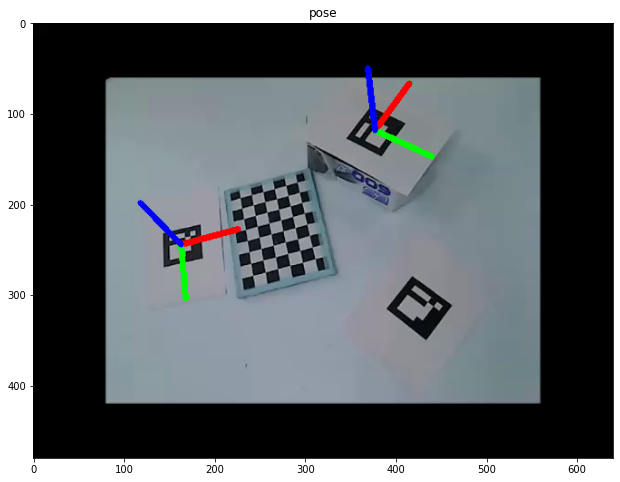

In [10]:
# Função que estima a pose dos casamentos
def estimate_pose(frame, matches, points, I, C):
    poses = []

    for index in range(len(matches)):
        
        ret, rotation, translation = cv2.solvePnP(points[index], matches[index].astype(float), I, C)
        
        if ret:
            poses.append((rotation, translation))
    
    return poses

# Função auxiliar que desenha axis na mesma posição 
# e com mesma orientação que o template.
# https://docs.opencv.org/4.x/d7/d53/tutorial_py_pose.html
def draw(img, corners, idx, center, imgpts):
    corner = tuple(corners[idx].astype(int).ravel())

    img = cv2.line(img, tuple(center.astype(int).ravel()), tuple(imgpts[0].astype(int).ravel()), (255,0,0), 5)
    img = cv2.line(img, tuple(center.astype(int).ravel()), tuple(imgpts[1].astype(int).ravel()), (0,255,0), 5)
    img = cv2.line(img, tuple(center.astype(int).ravel()), tuple(imgpts[2].astype(int).ravel()), (0,0,255), 5)
    
    return img

# Função auxiliar que plota os resultados
#https://docs.opencv.org/4.x/d7/d53/tutorial_py_pose.html
def draw_poses(frame, contours, angle_index, poses, Cam, Dis):
    image = frame.copy()
    for i, con in enumerate(contours):
        axis = np.float32([
            [CENTER_X - 3*DX, CENTER_Y, CENTER_Z], 
            [CENTER_X, CENTER_Y + 3*DY, CENTER_Z], 
            [CENTER_X, CENTER_Y, CENTER_Z + 2]
        ])

        center = np.float32([[CENTER_X, CENTER_Y, CENTER_Z]])

        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
        proj, jacob = cv2.projectPoints(axis, poses[i][0], poses[i][1], Cam, Dis)

        center, jacob = cv2.projectPoints(center, poses[i][0], poses[i][1], Cam, Dis)

        image = draw(image, con, angle_index[i], center, proj)
    
    return image



poses = estimate_pose(frame, matches, points, CAMERA, DISTCOEFS)

image = draw_poses(frame, matches, angle_index, poses, CAMERA, DISTCOEFS)

plt.subplots(figsize=(15, 8))
plt.imshow(image, cmap='gray'), plt.title("pose")
plt.show()

## Desenhar pikachu utilizando as poses detectadas

In [11]:
# Função que executa todo o pipeline
# de detecção do template em um frame
def pose_pipeline(frame):
    contours = square_contours(frame_contours(frame))
    matches, points, angle_index = find_matches(contours, frame, template)
    poses = estimate_pose(frame, matches, points, CAMERA, DISTCOEFS)
    
    if draw_axis:
        frame = draw_poses(frame, matches, angle_index, poses, CAMERA, DISTCOEFS)

    return poses, frame


# Função que cria uma matriz de View utilizando
# os vetores de rotação e transalação encontrados 
# no processo de estimação de pose dos templates
def get_view_matrix(R, T):
    R = cv2.Rodrigues(R)[0]

    V = np.array([[R[0][0], R[0][1], R[0][2], T[0][0]],        
                  [R[1][0], R[1][1], R[1][2], T[1][0]],
                  [R[2][0], R[2][1], R[2][2], T[2][0]], 
                  [0      ,0       ,0       , 1      ]])
    
    F = np.array([[1, 0,  0, 0],
                  [0, -1, 0, 0],
                  [0, 0, -1, 0],
                  [0, 0,  0, 1]])

    return np.transpose(np.dot(F, V))

In [12]:
# Load pikachu model
def load_pikachu():
    return OBJ('Pikachu.obj', swapyz=True)


verticies = ((0.5, -0.5, -0.5),(0.5, 0.5, -0.5),(-0.5, 0.5, -0.5),(-0.5, -0.5, -0.5),(0.5, -0.5, 0.5),(0.5, 0.5, 0.5),(-0.5, -0.5, 0.5),(-0.5, 0.5, 0.5))
edges = ((0,1),(0,3),(0,4),(2,1),(2,3),(2,7),(6,3),(6,4),(6,7),(5,1),(5,4),(5,7))

# Função para renderizar frame de video
# como background
def render_background(img):
    texture = glGenTextures(1)

    glBindTexture(GL_TEXTURE_2D, texture)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.flip(img, 0)

    H, W, C = img.shape

    byte_count = H * W * C
    
    img = np.frombuffer(img.tobytes(), dtype=img.dtype, count = byte_count)    
        
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_LINEAR)
    
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_LINEAR)
    
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGB, W, H, 0, GL_RGB, GL_UNSIGNED_BYTE, img)
    
    glDepthMask(GL_FALSE)
    
    glMatrixMode(GL_PROJECTION)
    
    glPushMatrix()
    
    glLoadIdentity()
    
    gluOrtho2D(0, W, 0, H)

    glEnable(GL_TEXTURE_2D)
    
    glBindTexture(GL_TEXTURE_2D, texture)
        
    glPushMatrix()
    
    glBegin(GL_QUADS)
    
    glTexCoord2f(0, 0)
    glVertex3f(0, 0, 1)
    
    glTexCoord2f(1, 0)
    glVertex3f(W, 0, 1)
    
    glTexCoord2f(1, 1) 
    glVertex3f(W, H, 1)
    
    glTexCoord2f(0, 1) 
    glVertex3f(0, H, 1)
    
    glEnd()
    
    glPopMatrix()
    
    glMatrixMode(GL_PROJECTION)
    
    glPopMatrix()
    
    glMatrixMode(GL_MODELVIEW)
    
    glBindTexture(GL_TEXTURE_2D, 0)
    glDepthMask(GL_TRUE)
    glFlush()

#render cube
def render_cube():
    glColor3f(1,1,1)

    glBegin(GL_LINES)
    for edge in edges:
        for vertex in edge:
            glColor3f(1,1,1)
            glVertex3fv(verticies[vertex])
    glEnd()

    glBegin(GL_LINES)
    glColor3f(1,0,0)
    glVertex3fv((0,0,0))
    glColor3f(1,0,0)
    glVertex3fv((0,0,1))
    glEnd()    
    
    glColor3f(1,1,1)

# Função que renderiza o pikachu e o cubo
def render_objects(angle, VIEW):
    glMatrixMode(GL_PROJECTION)

    glMatrixMode(GL_MODELVIEW)
        
    glLoadIdentity()            
    
    glPushMatrix()

    glLoadMatrixf(VIEW)
    
    glTranslatef(0, 0, -0.5)

    glRotatef(angle, 0, 0, 1);

    glScalef(.5, .5, .5)
    
    glEnable(GL_TEXTURE_2D)

    glCallList(pikachu_obj.gl_list)
    
    glTranslatef(0, 0, 0.5)
    
    glScalef(2, 2, 2)
    
    glRotatef(-angle, 0, 0, 1);

    render_cube()
    
    glPopMatrix()
    
    glFlush()

# Função de callback para o glut
# que irá executar todo o pipeline
# para renderizar o pikachu sobre o 
# frame
def render():
    global ANGLE
    global draw_axis
    global frame

    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    
    flag, frame = cap.read()
    
    ret = False
    
    if flag:
        ret = True
    
        poses, background = pose_pipeline(frame)
    
        render_background(background)

        for pose in poses:
            view_matrix = get_view_matrix(pose[0], pose[1])
            render_objects(ANGLE, view_matrix)    
        
        ANGLE = ANGLE + 1
    
    return ret
        
ANGLE = 0

cap = cv2.VideoCapture('entrada.mp4')

pg.init()

display = (640, 480)

pg.display.set_mode(display, DOUBLEBUF | OPENGL)

glClearDepth(1.0)
    
glEnable(GL_TEXTURE_2D)

glEnable(GL_DEPTH_TEST)
    
glMatrixMode(GL_PROJECTION)

gluPerspective(60, (640/480), 0.1, 50.0)

pikachu_obj = load_pikachu()

stop = False

clock = pg.time.Clock()

while not stop:
    for event in pg.event.get():
        if event.type == pg.QUIT:
            stop = True
    if stop:
        pg.quit()
        break
    
    flag = render()
    
    if not flag:
        pg.quit()
        break
    
    clock.tick(30)
    pg.display.flip()